In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
import json
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm.auto import tqdm
import copy
import torchmetrics.functional as tmf

import pandas as pd

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [2]:
class SlotIntentDataset(Dataset):
    
    def __init__(self, datapath):
        self.data = []
        with open(datapath, 'r') as jsonl_file:
            for line in jsonl_file:
                self.data.append(json.loads(line))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if sample['history']:
            last_history = sample['history'][-1]
            last_history_str = f"{last_history['user_query']}? {last_history['response_text']}"
        else:
            last_history_str = " "
        return (self.data[idx]['input'], last_history_str, self.data[idx]['output'])

def dl_collate_fn(batch):
    return list(batch)

## Training

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path = '/kaggle/input/col772a3-data/A3'

In [4]:
train_ds = SlotIntentDataset(f'{data_path}/train.jsonl')
val_ds = SlotIntentDataset(f'{data_path}/dev.jsonl')

In [5]:
import random
random.seed(42)

In [6]:
DEBUG = False
nr_epochs = 20
if DEBUG:
    train_ds.data = random.sample(train_ds.data, 2048)
    val_ds.data = random.sample(val_ds.data, 512)
    nr_epochs=2

In [7]:
train_dl = DataLoader(train_ds, batch_size=16, num_workers=2, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=2, shuffle=False)

In [8]:
intents = ['Send_digital_object',
 'Get_health_stats',
 'Get_message_content',
 'Add_contact',
 'Initiate_call',
 'Create_note',
 'Add_item_to_list',
 'Create_list',
 'Get_list',
 'Order_menu_item',
 'Find_parking',
 'Get_note',
 'Start_exercise',
 'Stop_exercise',
 'Resume_exercise',
 'Pause_exercise',
 'Log_exercise',
 'Log_nutrition',
 'Check_order_status',
 'Get_bill',
 'Get_security_price',
 'Open_app',
 'Pay_bill',
 'Get_product',
 'Other',
 'Post_message',
 'Record_video',
 'Take_photo',
 'Cancel_ride',
 'Order_ride',
 'BuyEventTickets',
 'Play_game',
 'GetGenericBusinessType'
]

intent_map = {
    intent: idx for idx, intent in enumerate(intents)
}

In [9]:
def wrap_single_example(eg):
    return f'[{eg[1]}] {eg[0]}'

def process_batch(batch, tokenizer):
    encoder_strs = [wrap_single_example(x) for x in zip(batch[0], batch[1])]
    labels = torch.tensor(
        [intent_map[toks.strip().split(' ')[0]] for toks in batch[2]]
    ).to(device)

    return labels, tokenizer(encoder_strs, return_tensors="pt", padding=True, truncation=True).to(device)

In [10]:
model = transformers.RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(intents))
# model.classifier.out_proj = nn.Linear(in_features=model.classifier.out_proj.in_features, out_features=len(intents), bias=True)
model = model.to(device)
tokenizer = transformers.AutoTokenizer.from_pretrained("roberta-base")
optimizer = optim.Adam(model.parameters(), lr=1e-5)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [11]:
def train(model, tokenizer, train_dl, val_dl, optimizer, scheduler=None, max_epochs=20, patience_lim=2):

    best_model = None
    best_model_errors = None
    best_val_loss = 10000
    val_losses = []
    train_losses = []
    accuracies = []
    f1_macros = []
    patience = 0

    for epoch in range(max_epochs):

        print(f'Epoch {epoch}:')
        errors = []
        train_loss = torch.tensor(0, dtype=torch.float, device=device)
        model.train()
        for batch in tqdm(train_dl):
            labels, tokens = process_batch(batch, tokenizer)
            
            optimizer.zero_grad()
            loss = model(**tokens, labels=labels).loss
            loss.backward()
            optimizer.step()

            train_loss += loss.detach()
        
        if scheduler:
            scheduler.step()

        train_loss = train_loss.cpu()
        train_loss /= len(train_dl)
        print(f' Train Loss: {train_loss}')
        train_losses.append(train_loss)

        val_loss = torch.tensor(0, dtype=torch.float, device=device)
        true_labels = []
        pred_labels = []
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dl):
                labels, tokens = process_batch(batch, tokenizer)

                outputs = model(**tokens, labels=labels)
                loss = outputs.loss
                true_labels.append(torch.argmax(outputs.logits, dim=1))
                pred_labels.append(labels)

                val_loss += loss.detach()
            
        val_loss = val_loss.cpu()
        val_loss /= len(val_dl)
        val_losses.append(val_loss)
        
        true_labels = torch.hstack(true_labels)
        pred_labels = torch.hstack(pred_labels)
        
        accuracy = (true_labels == pred_labels).count_nonzero()/len(true_labels)
        f1_macro = tmf.f1_score(pred_labels, true_labels, task='multiclass', average='macro', num_classes=len(intents))
        accuracies.append(accuracy)
        f1_macros.append(f1_macro)
        print(f' Val Loss: {val_loss}')
        print(f' Accuracy: {accuracy}')
        print(f' F1 Macro: {f1_macro}')
        print('')

        err_idxs = torch.where(true_labels != pred_labels)[0]
        for idx in err_idxs:
            errors.append({
                'prompt': wrap_single_example(val_dl.dataset[idx]),
                'pred': intents[pred_labels[idx]],
                'gold': intents[true_labels[idx]]
            })
    
        # early stopping
        if val_loss >= best_val_loss:
            if patience >= patience_lim:
                break
            else:
                patience += 1
        else:
            patience = 0
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            best_model_errors = copy.deepcopy(errors)
            best_model = best_model.cpu()
            print(f'best model: {epoch}')
    
    return best_model, best_model_errors, (train_losses, val_losses, accuracies, f1_macros)

In [12]:
best_model, best_errors, (train_losses, val_losses, accuracies, f1_macros) = train(model, tokenizer, train_dl, val_dl, optimizer, max_epochs=nr_epochs)
torch.save(best_model, 'intent-roberta.pt')

Epoch 0:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.583124041557312


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.09017637372016907
 Accuracy: 0.981988787651062
 F1 Macro: 0.976473331451416

best model: 0
Epoch 1:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.08187206089496613


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.06392635405063629
 Accuracy: 0.9869499802589417
 F1 Macro: 0.9834593534469604

best model: 1
Epoch 2:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.045805495232343674


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.058295316994190216
 Accuracy: 0.9873813986778259
 F1 Macro: 0.9833469986915588

best model: 2
Epoch 3:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.034150950610637665


  0%|          | 0/290 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8ed59009e0><function _MultiProcessingDataLoaderIter.__del__ at 0x7a8ed59009e0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
        self._shutdown_workers()
self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        assert self._parent_pid == os.getpid(), 'can o

 Val Loss: 0.06832141429185867
 Accuracy: 0.9870578646659851
 F1 Macro: 0.9832912087440491

Epoch 4:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.024955131113529205


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.06547467410564423
 Accuracy: 0.9871656894683838
 F1 Macro: 0.9837217926979065

Epoch 5:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.025310805067420006


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.06960418075323105
 Accuracy: 0.9855479001998901
 F1 Macro: 0.9817101955413818



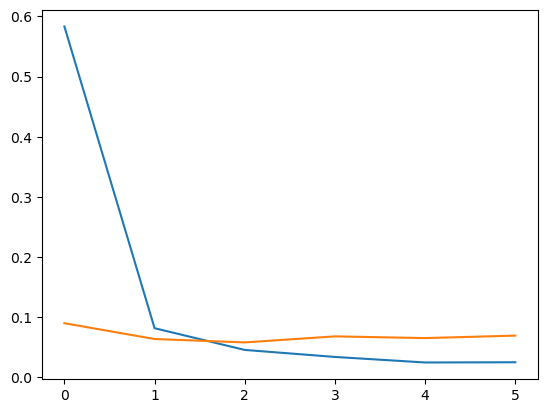

In [13]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)

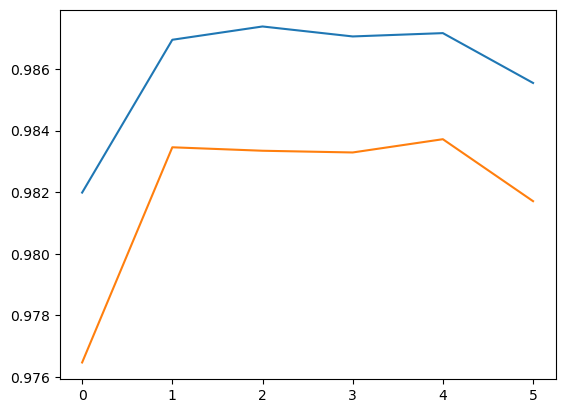

In [14]:
plt.plot(torch.tensor(accuracies).cpu())
plt.plot(torch.tensor(f1_macros).cpu())

In [15]:
json.dump(best_errors, open('roberta_errors.json', 'w'))